In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import os
import datetime as dt
import numpy as np
from copy import deepcopy
import seaborn as sns
from IPython.display import display

# Load

In [3]:
files = os.listdir("data")
# Sort dates
dates = [dt.datetime.strptime(re.findall(r'\d{4}-\d{2}-\d{2}',f)[0],'%Y-%m-%d') for f in files]
dates = sorted(dates,reverse=False)
dates = [i.strftime('%Y-%m-%d') for i in dates]

dfs_raw = {d: pd.read_csv(f'data/worldometers-{d}.tsv',sep="\t") for d in dates}

# Clean

In [4]:
dfs = deepcopy(dfs_raw)
for df in dfs.values():
    for i in range(1, df.shape[1] - 1):
        # Fill nan in numerical data with 0
        df.iloc[:,i] = df.iloc[:,i].fillna(0)
    # Fill categorical nan with Other
    df.iloc[:,-1] = df.iloc[:,-1].fillna('Other')
    df.iloc[:,0] = df.iloc[:,0].fillna('Other')    

# Active and Serious cases
1. What is the trend of active and serious cases?
2. Is there a relationship between active and serious cases?
3. Increasing rate of Serious cases in each region?

In [5]:
dfs[dates[0]]

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,Population,Continent
0,USA,80849953,53838.0,982032.0,1389.0,54136964.0,191175.0,25730957.0,7025.0,241891.0,2938.0,954367702.0,2855321.0,3.342418e+08,North America
1,India,42951556,6396.0,514620.0,201.0,42367070.0,13450.0,69866.0,8944.0,30622.0,367.0,770050005.0,548999.0,1.402643e+09,Asia
2,Brazil,28906214,64054.0,650646.0,594.0,26810286.0,142276.0,1445282.0,8318.0,134397.0,3025.0,63776166.0,296522.0,2.150808e+08,South America
3,France,22900531,60225.0,138942.0,180.0,21364892.0,131190.0,1396697.0,2484.0,349549.0,2121.0,246629975.0,3764506.0,6.551456e+07,Europe
4,UK,19074441,45571.0,161898.0,194.0,17537214.0,0.0,1375329.0,279.0,278536.0,2364.0,484240712.0,7071156.0,6.848113e+07,Europe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,Western Sahara,10,0.0,1.0,0.0,8.0,0.0,1.0,0.0,16.0,2.0,0.0,0.0,6.218230e+05,Africa
222,MS Zaandam,9,0.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,Other
223,Marshall Islands,7,0.0,0.0,0.0,7.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,5.985600e+04,Australia/Oceania
224,Saint Helena,2,0.0,0.0,0.0,2.0,0.0,0.0,0.0,327.0,0.0,0.0,0.0,6.107000e+03,Africa


# Trend

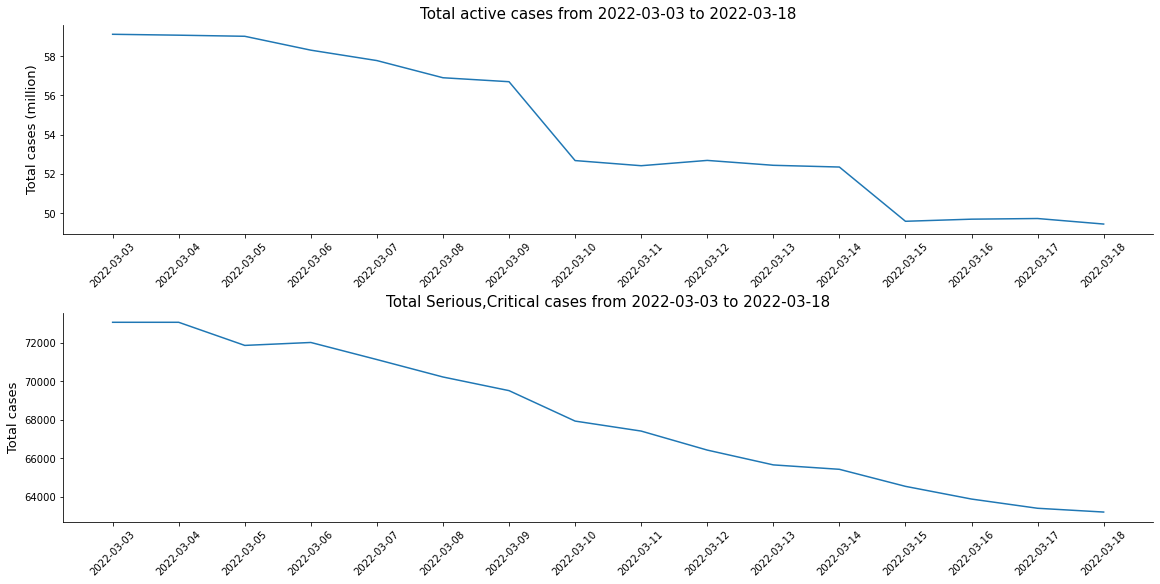

In [6]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8),constrained_layout = True)

ax1.tick_params(axis='x', labelrotation=45)
ax1.ticklabel_format(style='plain')
ax1.spines[['right','top']].set_visible(False)
ax1.set_title(f"Total active cases from {dates[0]} to {dates[-1]}",fontsize=15)
t = np.fromiter([dfs[d]['ActiveCases'].sum() for d in dates],dtype=int)
ax1.plot(dates, t/10**6)
ax1.set_ylabel('Total cases (million)',fontsize=13)

ax2.tick_params(axis='x', labelrotation=45)
ax2.ticklabel_format(style='plain')
ax2.spines[['right','top']].set_visible(False)
ax2.set_title(f"Total Serious,Critical cases from {dates[0]} to {dates[-1]}", fontsize=15)
ax2.plot(dates, [dfs[d]['Serious,Critical'].sum() for d in dates])
ax2.set_ylabel('Total cases',fontsize=13);

## Comment
- In general, total active cases and total serious cases are following a decreasing trend
- Number of active cases drops significantly
- Number of serious cases decreases slowly
- The trend is believed to be continued the next following days
- Vaccination seems to prove its worthy

# Continents' active, serious cases latest date

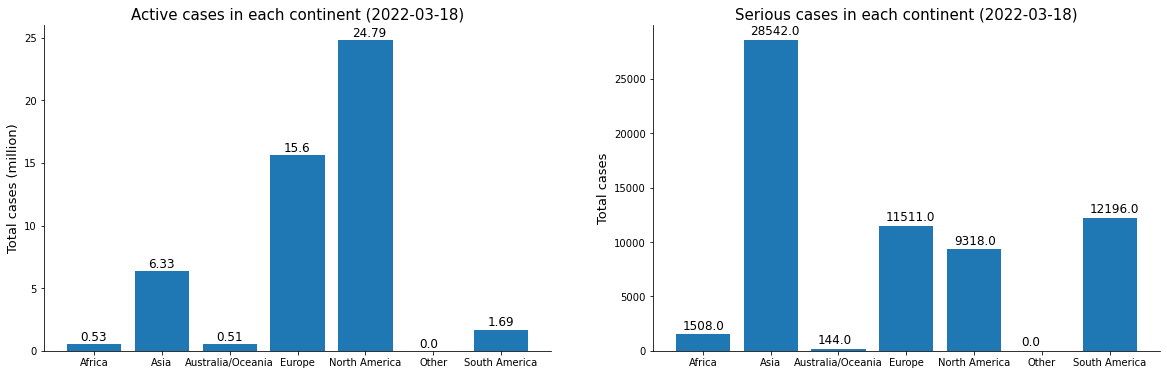

In [7]:
df_latest = dfs[dates[-1]]

ActiveCasesContinent = df_latest[['Continent','ActiveCases']].groupby(by='Continent').agg(['sum'])
SeriousCasesContinent = df_latest[['Continent','Serious,Critical']].groupby(by='Continent').agg(['sum'])

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,6))
t = ActiveCasesContinent.values.reshape((1, -1))[0]
ax1.bar(ActiveCasesContinent.index, t/10**6)
ax1.spines[['right','top']].set_visible(False)
ax1.ticklabel_format(axis='y', style='plain')
ax1.set_title(f"Active cases in each continent ({dates[-1]})",fontsize=15)
ax1.set_ylabel('Total cases (million)',fontsize=13)
for i, v in enumerate(np.round(t/10**6,2)):
    ax1.text(i-0.2, v+0.3, str(v),color='black',fontsize=12)

t = SeriousCasesContinent.values.reshape((1, -1))[0]
ax2.bar(SeriousCasesContinent.index, t)
ax2.spines[['right','top']].set_visible(False)
ax2.ticklabel_format(axis='y', style='plain')
ax2.set_title(f"Serious cases in each continent ({dates[-1]})",fontsize=15)
ax2.set_ylabel('Total cases',fontsize=13)
for i, v in enumerate(t):
    ax2.text(i-0.3, v+500, str(v),color='black',fontsize=12);

## Comment
- North America dominates other continents with the highest number to active cases
- Although the nubmer of active cases in Asia is not too large, the number of serious case in this continent seems to be outweighting other continents
- The number active cases and serious cases in *Other* continent is abnormal
- Countries of *Other* continent seems to ones of the outliers since the provided data are not updated

In [8]:
df_latest[df_latest['Continent']=='Other'] 

,"Country,Other",TotalCases,NewCases,TotalDeaths,NewDeaths,TotalRecovered,NewRecovered,ActiveCases,"Serious,Critical",Tot Cases/1M pop,Deaths/1M pop,TotalTests,Tests/1M pop,Population,Continent
212,Diamond Princess,712,0.0,13.0,0.0,699.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other
222,MS Zaandam,9,0.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other


# World Active cases and serious cases relationship

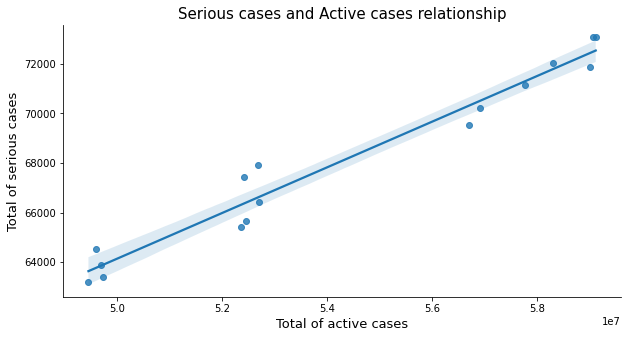

In [9]:
t1 = np.fromiter([dfs[d]['Serious,Critical'].sum() for d in dates],dtype=int)
t2 = np.fromiter([dfs[d]['ActiveCases'].sum() for d in dates],dtype=int)
fig, ax = plt.subplots(1,1,figsize=(10,5))
sns.regplot(x=t2,y=t1, ax=ax)
ax.spines[['right','top']].set_visible(False)
ax.set_ylabel("Total of serious cases", fontsize=13)
ax.set_xlabel("Total of active cases", fontsize=13)
ax.set_title("Serious cases and Active cases relationship", fontsize=15);

## Comment
- The Serious cases and active cases have a linear relationship
- However, the number of serious cases increase slowly while the number of active cases increases
- This could be a result of vaccination or better health support from countries